In [86]:
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [87]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')   

#categories_filter = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

#for x in categories_filter:
#    df.drop(df.index[df[x] == 'unknown'], inplace=True)

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

In [88]:
#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['job']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [89]:
undersample = NearMiss(version=1, n_neighbors_ver3=3)
features, y = undersample.fit_resample(features, y)

In [90]:
#Boosting the tree and predicting with ROC curve and classification reports
def gradient_boosted_tree(features, targets):
    train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
    ensemble = GradientBoostingClassifier(max_depth=1, n_estimators=3243 ,random_state=23)
    
    k = 10
    kf = KFold(n_splits=k, shuffle = True)

    
    dt_scores = cross_val_score(ensemble, train_features, train_targets, scoring ='roc_auc' ,cv = kf)
    dt_scores1 = cross_val_score(ensemble, train_features, train_targets, scoring ='accuracy' ,cv = kf)
    print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))
    print("mean accuracy: {}".format(np.round(np.mean(dt_scores1),3)))

    ensemble.fit(train_features, train_targets)
    predictions = ensemble.predict(test_features)
    
    print("Confusion Matrix:")
    print(confusion_matrix(test_targets, predictions))

    print("Classification Report")
    print(classification_report(test_targets, predictions))
    
    #Beginning the plotting of ROC-curve
    pred_prob = ensemble.predict_proba(test_features)
    fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
    #Plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Boosted Trees')

    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    
    #AUC Score
    auc_score = roc_auc_score(test_targets, pred_prob[:,1])
    print("AUC Score: " + str(np.round(auc_score , 3)))
    
    #Log-loss function
    print("Log-Loss: " + str(np.round(log_loss(test_targets, predictions),3)))

mean cross validation score: 0.927
mean accuracy: 0.84
Confusion Matrix:
[[815 120]
 [153 768]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       935
           1       0.86      0.83      0.85       921

    accuracy                           0.85      1856
   macro avg       0.85      0.85      0.85      1856
weighted avg       0.85      0.85      0.85      1856



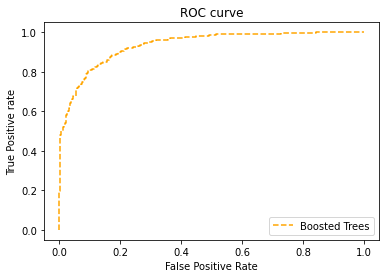

AUC Score: 0.936
Log-Loss: 5.08


In [91]:
gradient_boosted_tree(features, y.values.ravel())

In [50]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
ensemble = GradientBoostingClassifier(max_depth=1, n_estimators=1000 ,random_state=23).fit(
        train_features, train_targets)
param_grid = {'n_estimators': range(3240,3250,1)}
grid = GridSearchCV(ensemble,param_grid,refit=True,verbose=2)
grid.fit(train_features,train_targets)
print(grid.best_estimator_)

grid_predictions = grid.predict(test_features)
print(confusion_matrix(test_targets,grid_predictions))
print(classification_report(test_targets,grid_predictions))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..................................n_estimators=3240; total time=  11.1s
[CV] END ..................................n_estimators=3240; total time=  12.8s
[CV] END ..................................n_estimators=3240; total time=  13.8s
[CV] END ..................................n_estimators=3240; total time=  13.9s
[CV] END ..................................n_estimators=3240; total time=  12.5s
[CV] END ..................................n_estimators=3241; total time=  12.0s
[CV] END ..................................n_estimators=3241; total time=  11.6s
[CV] END ..................................n_estimators=3241; total time=  11.4s
[CV] END ..................................n_estimators=3241; total time=  12.8s
[CV] END ..................................n_estimators=3241; total time=  11.8s
[CV] END ..................................n_estimators=3242; total time=  11.3s
[CV] END ..................................n_est

>1, train: 0.931, test: 0.910
>2, train: 0.976, test: 0.898
>3, train: 0.998, test: 0.890
>4, train: 1.000, test: 0.896
>5, train: 1.000, test: 0.894
>6, train: 1.000, test: 0.890
>7, train: 1.000, test: 0.890
>8, train: 1.000, test: 0.899
>9, train: 1.000, test: 0.887
>10, train: 1.000, test: 0.896


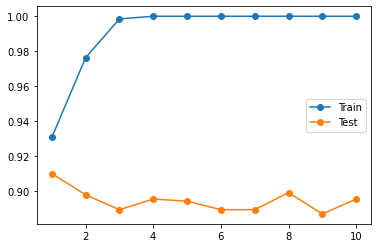

In [32]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 11)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = GradientBoostingClassifier(max_depth=i, n_estimators=1000, random_state=23).fit(
        train_features, train_targets)
	# evaluate on the train dataset
	schatting = model.predict(train_features)
	train_acc = accuracy_score(train_targets, schatting)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_schatting = model.predict(test_features)
	test_acc = accuracy_score(test_targets, test_schatting)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()
